# Exploring Batch 3 Replicate Correlation

**Gregory Way, 2019**

In [1]:
import os
import numpy as np
import pandas as pd
import plotnine as gg

In [2]:
def get_pairwise_corr(x_df):
    x_cor_df = x_df.loc[:, ~x_df.columns.str.startswith("Metadata")].transpose().corr()
    x_cor_df = x_cor_df.where(pd.np.tril(pd.np.ones(x_cor_df.shape), k=-1).astype(bool))
    x_cor_df.index = x_df.Metadata_clone_number
    x_cor_df.columns = x_df.Metadata_clone_number
    x_cor_df.index.name = "{}_b".format(x_cor_df.index.name)
    x_cor_df = x_cor_df.stack().reset_index().rename({0: "correlation"}, axis='columns')
    x_cor_df = x_cor_df.assign(replicate=x_cor_df.iloc[:, 0] == x_cor_df.iloc[:, 1])
    return x_cor_df

def plot_replicate_corr(x_df):
    plot_obj = gg.ggplot(x_df, gg.aes(x="correlation", fill="replicate")) + \
        gg.geom_density(alpha = 0.3) + \
        gg.scale_fill_manual(name="Replicate",
                             labels={"True": "True",
                                     "False": "False"},
                             values=["#B99638", "#2DB898"]) + \
        gg.xlab("Pearson Correlation") + \
        gg.ylab("Density") + \
        gg.theme_light()
    return plot_obj

def plot_individual_replicate_corr(x_df):
    # Process input data to ensure all sample correlations are captured in
    # one column, but that replicate correlation is not captured
    left_df = (
        x_df
        .loc[:, ["Metadata_clone_number_b", "correlation", "replicate"]]
        .reset_index(drop=True)
        .rename({"Metadata_clone_number_b": "Metadata_clone_number"}, axis='columns')
    )
    right_df = (
        x_df
        .loc[:, ["Metadata_clone_number", "correlation", "replicate"]]
        .query("replicate == False")
        .reset_index(drop=True)
    )

    x_df = pd.concat([left_df, right_df], axis='rows', ignore_index=True)

    # Now plot
    plot_obj = gg.ggplot(x_df, gg.aes(y="correlation", x="replicate", fill="replicate")) + \
        gg.geom_jitter(shape = ".", size=0.5, alpha=0.3) + \
        gg.geom_boxplot(alpha=0.3, outlier_alpha=0) + \
        gg.scale_fill_manual(name="Replicate",
                             labels={"True": "True",
                                     "False": "False"},
                             values=["#B99638", "#2DB898"]) + \
        gg.xlab("Replicates") + \
        gg.ylab("Pearson Correlation") + \
        gg.theme_light() + \
        gg.theme(subplots_adjust={'wspace': 0.2},
                 axis_text=gg.element_text(size=7),
                 axis_title=gg.element_text(size=9),
                 strip_text=gg.element_text(size=6, color="black"),
                 strip_background=gg.element_rect(colour="black",
                                                  fill="#fdfff4")) + \
        gg.facet_wrap("~Metadata_clone_number")
    return plot_obj

In [3]:
batch = "2019_06_25_Batch3"
backend_dir = os.path.join("..", "..", "backend", batch)

backend_folders = os.listdir(backend_dir)
mut_file, wt_file = [
    os.path.join(backend_dir, x, "{}_normalized_variable_selected.csv".format(x))
    for x in backend_folders
]

print(mut_file)
print(wt_file)

../../backend/2019_06_25_Batch3/MutClones/MutClones_normalized_variable_selected.csv
../../backend/2019_06_25_Batch3/WTClones/WTClones_normalized_variable_selected.csv


## Read in Files

In [4]:
mut_df = pd.read_csv(mut_file)

print(mut_df.shape)
mut_df.head(2)

(57, 191)


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_Correlation_AGP_20_00,Nuclei_Texture_Correlation_AGP_20_03,Nuclei_Texture_Correlation_AGP_5_00,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_5_00,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_AGP_20_02,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_InverseDifferenceMoment_ER_20_02
0,MutClones,B02,MutClones,MutClones,B02,BZ001,0.603442,-3.05703,0.050689,0.658574,...,3.358292,1.126295,0.00000,1.204256,0.420668,0.570578,-1.320394,-0.224753,1.311671,0.212493
1,MutClones,B03,MutClones,MutClones,B03,BZ002,-1.029542,-1.41911,1.114270,-0.934509,...,-0.306876,1.536572,-4.29316,3.379792,-6.815724,0.418180,3.899485,2.166751,2.502230,2.646517


In [5]:
wt_df = pd.read_csv(wt_file)

print(wt_df.shape)
wt_df.head(2)

(48, 191)


,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_clone_number,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,...,Nuclei_Texture_Correlation_AGP_20_00,Nuclei_Texture_Correlation_AGP_20_03,Nuclei_Texture_Correlation_AGP_5_00,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_5_00,Nuclei_Texture_Correlation_RNA_20_02,Nuclei_Texture_InfoMeas1_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_AGP_20_02,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_InverseDifferenceMoment_ER_20_02
0,WTClones,B02,WTClones,WTClones,B02,WT001,-0.681656,0.243369,0.554328,0.277293,...,-1.992909,-0.562482,-0.731103,-1.798579,-2.054019,-1.270827,0.671665,-0.082571,0.454421,-0.610071
1,WTClones,B03,WTClones,WTClones,B03,WT001,0.051251,-0.497039,-0.104530,0.072575,...,-1.922169,-0.771678,-0.159481,-1.284761,0.017824,-0.692174,-0.068783,-0.443550,0.289183,-0.577381


## How Many Replicates?

In [6]:
mut_df.Metadata_clone_number.value_counts()

BZ016          3
BZ007          3
BZ014          3
BZ017          3
BZ001          3
BZ006          3
BZ002          3
BZ018          3
BZ013          3
BZ015          3
BZ004          3
BZ008          3
WT_parental    3
BZ010          3
BZ011          3
BZ012          3
BZ009          3
BZ005          3
BZ003          3
Name: Metadata_clone_number, dtype: int64

In [7]:
wt_df.Metadata_clone_number.value_counts()

WT011          3
WT012          3
WT002          3
WT001          3
WT015          3
WT003          3
WT013          3
WT014          3
WT008          3
WT010          3
WT007          3
WT009          3
WT_parental    3
WT006          3
WT005          3
WT004          3
Name: Metadata_clone_number, dtype: int64

## Get Pairwise Correlations

In [8]:
mut_cor_df = get_pairwise_corr(mut_df)

print(mut_cor_df.shape)
mut_cor_df.head()

(1596, 4)


,Metadata_clone_number_b,Metadata_clone_number,correlation,replicate
0,BZ002,BZ001,-0.010525,False
1,BZ003,BZ001,0.123059,False
2,BZ003,BZ002,-0.024515,False
3,BZ004,BZ001,0.056227,False
4,BZ004,BZ002,-0.026847,False


In [9]:
wt_cor_df = get_pairwise_corr(wt_df)

print(wt_cor_df.shape)
wt_cor_df.head()

(1128, 4)


,Metadata_clone_number_b,Metadata_clone_number,correlation,replicate
0,WT001,WT001,0.704606,True
1,WT001,WT001,-0.030090,True
2,WT001,WT001,-0.084275,True
3,WT002,WT001,0.168308,False
4,WT002,WT001,0.364070,False


## Plot Replicate Correlation

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/wt_correlation_2019_06_25_Batch3.png
  warn('Filename: {}'.format(filename))


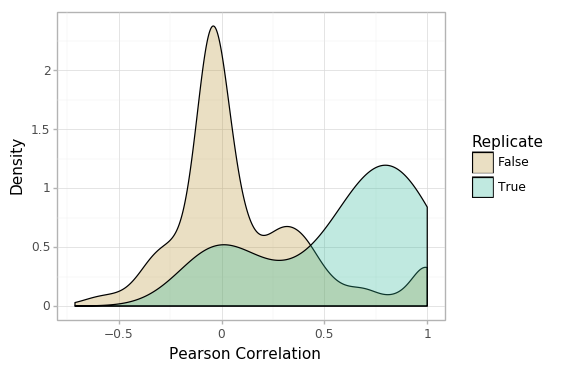

<ggplot: (8745388126717)>

In [10]:
wt_cor_gg = plot_replicate_corr(wt_cor_df)

file = os.path.join("figures", "wt_correlation_{}.png".format(batch))
wt_cor_gg.save(filename=file, height=4, width=5, dpi=300)

wt_cor_gg

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/mut_correlation_2019_06_25_Batch3.png
  warn('Filename: {}'.format(filename))


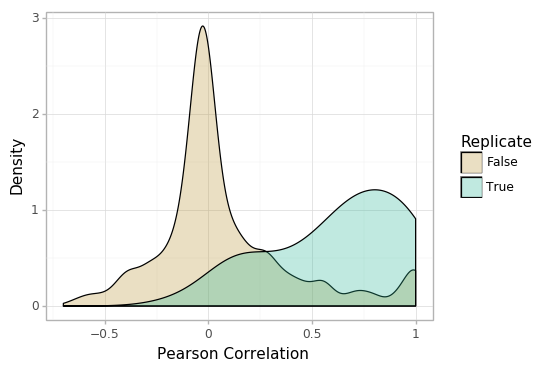

<ggplot: (8745388106248)>

In [11]:
mut_cor_gg = plot_replicate_corr(mut_cor_df)

file = os.path.join("figures", "mut_correlation_{}.png".format(batch))
mut_cor_gg.save(filename=file, height=4, width=5, dpi=300)

mut_cor_gg

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/wt_correlation_individual_2019_06_25_Batch3.png
  warn('Filename: {}'.format(filename))


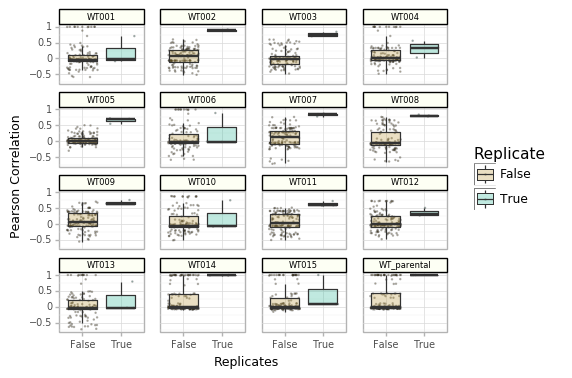

<ggplot: (8745388027442)>

In [12]:
wt_cor_individual_gg = plot_individual_replicate_corr(wt_cor_df)

file = os.path.join("figures", "wt_correlation_individual_{}.png".format(batch))
wt_cor_individual_gg.save(filename=file, height=4, width=5, dpi=300)

wt_cor_individual_gg

/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 4 in image.
  from_inches(height, units), units))
/home/ubuntu/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/mut_correlation_individual_2019_06_25_Batch3.png
  warn('Filename: {}'.format(filename))


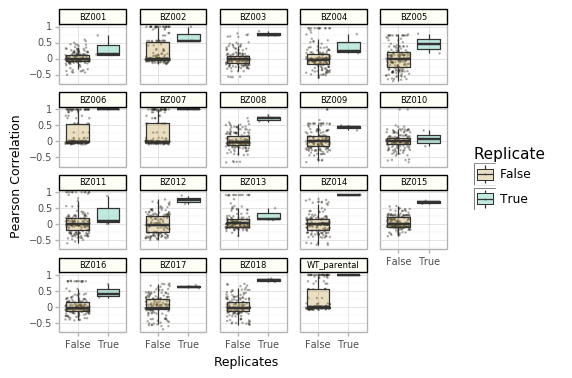

<ggplot: (8745385368675)>

In [13]:
mut_cor_individual_gg = plot_individual_replicate_corr(mut_cor_df)

file = os.path.join("figures", "mut_correlation_individual_{}.png".format(batch))
mut_cor_individual_gg.save(filename=file, height=4, width=5, dpi=300)

mut_cor_individual_gg

## Output Median Replicate Correlation

In [14]:
wt_median_cor_df = (
    wt_cor_df
    .groupby(["Metadata_clone_number", "replicate"])
    .median()
    .reset_index()
)

mut_median_cor_df = (
    mut_cor_df
    .groupby(["Metadata_clone_number", "replicate"])
    .median()
    .reset_index()
)

# Save Files
file = os.path.join("results", "WT_median_replicate_correlation.tsv")
wt_median_cor_df.to_csv(file, sep='\t', index=False)

file = os.path.join("results", "MUT_median_replicate_correlation.tsv")
mut_median_cor_df.to_csv(file, sep='\t', index=False)